In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException        

from time import sleep
from os import getcwd
from warnings import warn
from ipywidgets.widgets import interact, IntSlider
from IPython.display import display, Markdown

import statsmodels.api as sm
import statsmodels.formula.api as smf

from OLSplots import allplots # Module from Jason Sadowski at https://github.com/j-sadowski/FromRtoPython/blob/master/OLSplots.py

In [2]:
class Data:
    index = ["strongly_agree", "agree", "neutral", "disagree", "strongly_disagree", "na", "responses"]
    columns = ["effective_prof", "worthwhile_course", "help_available", "workload", "course_organization", "course_interest"]
    
    def _repr_html_(self):
        try:
            output = ""
            output += "<p>"+self.subject+" " + self.course+"</p>"
            output += "<p>"+self.subject_desc+"</p>"
            output += "<p>"+self.course_desc+"</p>"
            output += "<p>"+self.prof+"</p>"
            output += "<p>"+self.semesters+"</p>"
            output += self.table._repr_html_()
            return output
        except:
            return "Incomplete Data"
    
    def read_page(self):
        info_prof, info_course, info_semesters = soct_driver.find_elements(By.XPATH, "//dd")
        self.prof = info_prof.text
        info_course, self.course_desc = info_course.text.split(" - ", 1)
        self.subject, self.course, self.subject_desc = info_course.split(" ", 2)
        self.semesters = info_semesters.text
        
        table = []
        for row in soct_driver.find_elements(By.XPATH, "//table[@id='student-responses']/tbody/tr"):
            row_data = []
            for val in row.find_elements(By.XPATH, "./td[@class='bar-cell text-center']/table/tbody/tr/td[1]/p"):
                row_data.append(val.text)
            num_responses = row.find_element(By.XPATH, "./td[not(@class)]/p[1]").text.split(" = ")[1]
            row_data.append(num_responses)
            table.append(row_data)
        self.table = pd.DataFrame(table, index=Data.columns, columns=Data.index).T
        
    def save_data(data_list, folder):
        with open(folder+"/prof.txt", "w") as prof:
            for value in [data.prof for data in data_list]:
                prof.write(value+"\n")
        
        with open(folder+"/course_desc.txt", "w") as course_desc:
            for value in [data.course_desc for data in data_list]:
                course_desc.write(value+"\n")
        
        with open(folder+"/subject.txt", "w") as subject:
            for value in [data.subject for data in data_list]:
                subject.write(value+"\n")
        
        with open(folder+"/course.txt", "w") as course:
            for value in [data.course for data in data_list]:
                course.write(value+"\n")
        
        with open(folder+"/subject_desc.txt", "w") as subject_desc:
            for value in [data.subject_desc for data in data_list]:
                subject_desc.write(value+"\n")
        
        with open(folder+"/semesters.txt", "w") as semesters:
            for value in [data.semesters for data in data_list]:
                semesters.write(value+"\n")
        
        for i, data in enumerate(data_list):
            data.table.to_csv(folder+"/dataframe"+str(i)+".csv")
            
    def load_data(folder):
        with open(folder+"/prof.txt", "r") as prof:
            prof_list = prof.readlines()
            prof_list = [line.rstrip() for line in prof_list]
        
        with open(folder+"/course_desc.txt", "r") as course_desc:
            course_desc_list = course_desc.readlines()
            course_desc_list = [line.rstrip() for line in course_desc_list]
        
        with open(folder+"/subject.txt", "r") as subject:
            subject_list = subject.readlines()
            subject_list = [line.rstrip() for line in subject_list]
        
        with open(folder+"/course.txt", "r") as course:
            course_list = course.readlines()
            course_list = [line.rstrip() for line in course_list]
        
        with open(folder+"/subject_desc.txt", "r") as subject_desc:
            subject_desc_list = subject_desc.readlines()
            subject_desc_list = [line.rstrip() for line in subject_desc_list]
        
        with open(folder+"/semesters.txt", "r") as semesters:
            semesters_list = semesters.readlines()
            semesters_list = [line.rstrip() for line in semesters_list]
        
        if not len(prof_list) == len(course_desc_list) == len(subject_list) == len(course_list) == len(subject_desc_list) == len(semesters_list):
            raise RuntimeError("Files contain data of different lengths")
        
        table_list = [pd.read_csv(folder+"/dataframe"+str(i)+".csv", index_col=0) for i in range(len(prof_list))]
        
        output = []
        for prof, course_desc, subject, course, subject_desc, semesters, table in zip(prof_list, course_desc_list, subject_list, course_list, subject_desc_list, semesters_list, table_list):
            data_obj = Data()
            data_obj.prof = prof
            data_obj.course_desc = course_desc
            data_obj.subject = subject
            data_obj.course = course
            data_obj.subject_desc = subject_desc
            data_obj.semesters = semesters
            data_obj.table = table
            output.append(data_obj)
            
        return output

In [78]:
soct_driver = webdriver.Chrome(service=Service(f'{getcwd()}/chromedriver.exe'))
soct_driver.get("https://soct.msu.edu/")

In [79]:
def log_in():
    soct_driver.find_element(By.ID, "msu-id").send_keys(<insert username here>)
    soct_driver.find_element(By.ID, "password").send_keys(<insert password here>)
    soct_driver.find_element(By.ID, "login-submit").click()
    
def home():
    soct_driver.find_element(By.ID, "section-home").click()
        
def back():
    soct_driver.execute_script("window.history.go(-1)")

def get_subjects():
    return Select(soct_driver.find_element(By.ID, "Select_SubjectCode"))
    
def get_courses():
    return Select(soct_driver.find_element(By.ID, "Select_CourseNumber"))
    
def get_profs():
    return Select(soct_driver.find_element(By.ID, "Select_Instructor"))
    
def check_received():
    return not len(soct_driver.find_elements(By.XPATH, "//*[contains(text(), 'No SOCT forms were received')]"))

def check_sufficient():
    return not len(soct_driver.find_elements(By.XPATH, "//h1[contains(text(), 'Insufficient data')]"))

def subjects_iterate(sample = False):
    subjects = get_subjects()
    for subj_idx in range(0, 3 if sample else len(subjects.options)):
        subjects.select_by_index(subj_idx)
        soct_driver.find_element(By.ID, "submit_subjectcode_1").click()
        courses_iterate()
        back()
        subjects = get_subjects()
        
def courses_iterate():
    courses = get_courses()
    for course_idx in range(len(courses.options)):
        courses.select_by_index(course_idx)
        soct_driver.find_element(By.ID, "submit_coursenumber_1").click()
        if check_received():
            profs_iterate()
        back()
        courses = get_courses()

def profs_iterate():
    profs = get_profs()
    for prof_idx in range(len(profs.options)):
        profs.select_by_index(prof_idx)
        soct_driver.find_element(By.ID, "submit_instructor_1").click()
        if check_sufficient():
            data_obj = Data()
            data_obj.read_page()
            searches.append(data_obj)
        back()
        profs = get_profs() 

In [80]:
log_in()
searches = []
subjects_iterate(True)

Data.save_data(searches, "sample_output")

KeyboardInterrupt: 

In [3]:
searches = Data.load_data("output")

In [4]:
def display_searches(searches):
    @interact(Index = IntSlider(min=0, max=len(searches)-1, step=1, value=0))
    def inner(Index):
        return searches[Index]
    
display_searches(searches)

interactive(children=(IntSlider(value=0, description='Index', max=2519), Output()), _dom_classes=('widget-inte…

In [5]:
def weighted_average(column):
    weights = [1, .75, .5, .25, 0]
    column = column[:5].str.strip("%").astype(float)/100*weights
    return sum(column)

In [6]:
data_list = []

for data in searches:
    values = {"subject": data.subject, 
              "course": data.course,
              "prof": data.prof}
    
    for var in data.columns:
        values[var] = weighted_average(data.table[var])
        
    data_list.append(values)
    
soct_data = pd.DataFrame(data_list)

In [7]:
soct_data

,subject,course,prof,effective_prof,worthwhile_course,help_available,workload,course_organization,course_interest
0,AAE,220,Andrew S McCullough,0.874925,0.854175,0.833325,0.791675,0.750000,0.791675
1,AAE,220,David Krise,0.937500,0.906250,0.906250,0.906250,0.906250,0.937500
2,AAE,220,Laura Marian Ramm-Christensen,0.931825,0.931825,0.931825,0.909100,0.925000,0.909100
3,AAE,221,Carol Elaine Arnold,0.916675,0.888900,0.972225,0.944450,0.972225,0.944450
4,AAE,222,Carol Wilson-Duffy,0.937500,0.906250,0.937500,0.937500,0.937500,0.890625
...,...,...,...,...,...,...,...,...,...
2515,WS,301,Laura Jean Apol,0.821375,0.839325,0.857175,0.803625,0.821450,0.839325
2516,WS,304,Hillery Glasby,0.980775,0.942300,0.903875,0.884625,0.942300,0.903850
2517,WS,403,Yuanfang Dai,0.825000,0.837500,0.837500,0.812500,0.787500,0.812500
2518,WS,424,Kristin Mahoney,0.950000,0.950000,1.000000,0.900000,0.950000,0.950000


In [8]:
soct_data.to_csv("soct_data.csv")

In [9]:
soct_data = pd.read_csv("soct_data.csv", index_col=0)

In [10]:
spring21 = pd.read_csv("spring21_grades.csv")
spring21.drop(["term_code", "crse_title", "sctn_code", "term_seq_id"], axis=1, inplace=True)
spring21["Instructor"] = spring21.Instructor.str.split(" \| ")
spring21 = spring21.explode("Instructor")
spring21 = spring21.groupby(["subj_code", "crse_code", "Instructor"]).sum().reset_index()

In [11]:
soct_data["prof_list"] = soct_data.prof.str.lower().str.split(" |-|,").apply(lambda x: tuple(sorted([x for x in x if len(x)>1])))
spring21["Instructor_list"] = spring21.Instructor.str.lower().str.split(" |-|,").apply(lambda x: tuple(sorted([x for x in x if len(x)>1])))

In [12]:
df = soct_data.merge(spring21, left_on=["subject", "course"], right_on=["subj_code", "crse_code"])
df.drop(["subj_code", "crse_code"], axis=1, inplace=True)

In [13]:
df["similarity_score"] = df.apply(lambda x: len(set(x.prof_list) & set(x.Instructor_list)), axis=1)

In [14]:
df = df[df.similarity_score>0]

In [15]:
df = df[df.similarity_score == df.groupby(["subject", "course", "prof"]).similarity_score.transform("max")]
df.groupby(["subject", "course", "prof"]).similarity_score.transform("count").value_counts()

1    1346
Name: similarity_score, dtype: int64

In [16]:
questionable_cases = df[df.similarity_score==1][["prof", "Instructor"]].drop_duplicates()

In [17]:
@interact(Index = IntSlider(min=0, max=len(questionable_cases)-1, step=1, value=0))
def inner(Index):
    display(questionable_cases.iloc[Index:Index+1])

interactive(children=(IntSlider(value=0, description='Index', max=52), Output()), _dom_classes=('widget-intera…

In [18]:
wrong_matches = [124, 303, 1015, 1491, 1822, 2891, 3134, 4221, 4745, 5019, 6191, 7477]
df = df.drop(wrong_matches, axis=0)
df.drop(df.loc[:,"I":], axis=1, inplace=True)
df.drop(df.loc[:,"prof_list":"Total Grades"], axis=1, inplace=True)
df.drop("prof", axis=1, inplace=True)

In [19]:
df["total_grades"] = df.loc[:,"4":"0"].sum(axis=1)

df = df[df.total_grades > 5].reset_index()

grade_vals = [4, 3.5, 3, 2.5, 2, 1.5, 1, 0]
grade_cols = [str(grade_val) for grade_val in grade_vals]

for grade_col in grade_cols:
    df["p"+grade_col] = df[grade_col]/df.total_grades
    
df["avg_grade"] = sum([df["p"+grade_str]*grade_num for grade_str, grade_num in zip(grade_cols, grade_vals)])

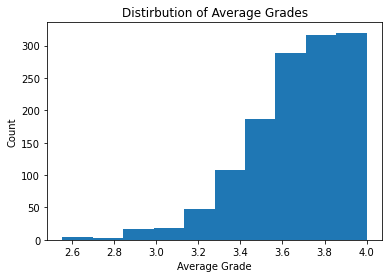

In [20]:
plt.hist(df.avg_grade)
plt.title("Distirbution of Average Grades")
plt.xlabel("Average Grade")
plt.ylabel("Count")
plt.show()

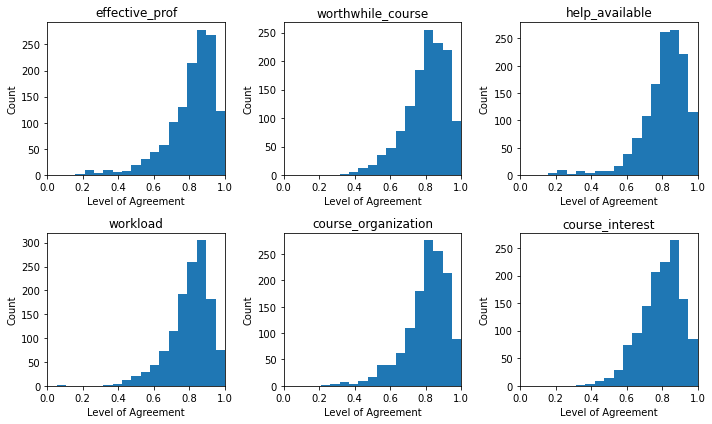

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for ax, var in zip(axs.flat, Data.columns):
    ax.hist(df[var], bins=np.linspace(0,1,20))
    ax.set_title(var)
    ax.set_xlabel("Level of Agreement")
    ax.set_ylabel("Count")
    ax.set_xlim(0,1)

plt.tight_layout()
plt.show()

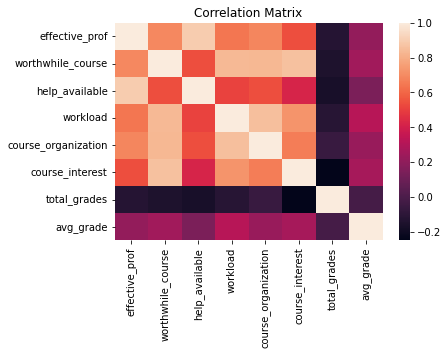

In [22]:
sns.heatmap(df[Data.columns + ["total_grades", "avg_grade"]].corr())
plt.title("Correlation Matrix")
plt.show()

In [23]:
models = [smf.ols("avg_grade ~ "+var, df).fit() for var in Data.columns]

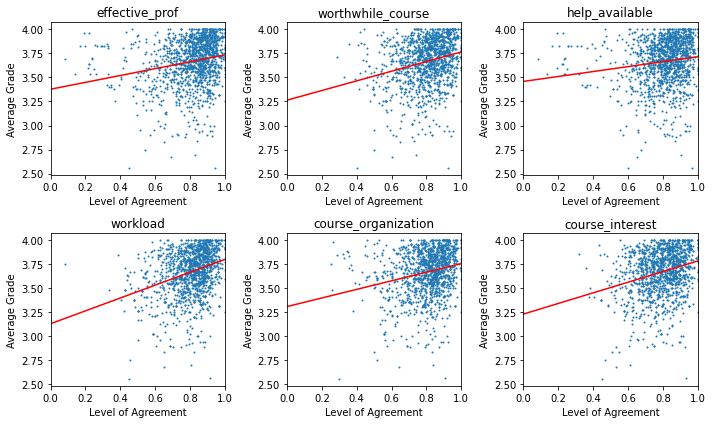

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for ax, var, model in zip(axs.flat, Data.columns, models):
    ax.scatter(df[var], df.avg_grade, s=1)
    
    x = np.linspace(0,1,100)
    y = model.predict({var:x})
    ax.plot(x, y, "red")
    
    ax.set_title(var)
    ax.set_xlabel("Level of Agreement")
    ax.set_ylabel("Average Grade")
    ax.set_xlim(0,1)

plt.tight_layout()
plt.show()

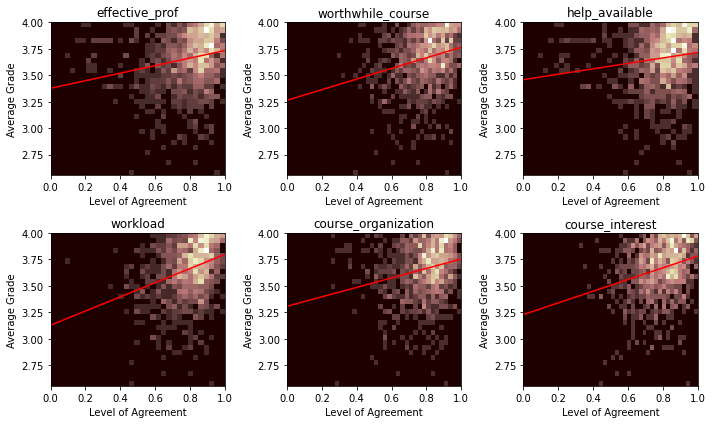

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for ax, var, model in zip(axs.flat, Data.columns, models):
    im = ax.hist2d(df[var], df.avg_grade, bins=30, cmap="pink", vmin=0)
    
    x = np.linspace(0,1,100)
    y = model.predict({var:x})
    ax.plot(x, y, "red")
    
    ax.set_title(var)
    ax.set_xlabel("Level of Agreement")
    ax.set_ylabel("Average Grade")
    ax.set_xlim(0,1)
    ax.set_facecolor((0.1178, 0, 0, 1))

plt.tight_layout()
plt.show()

In [26]:
results_list = []

for model in models:
    values = {"rsquared": model.rsquared,
              "rsquared_adj": model.rsquared_adj,
              "intercept": model.params[0],
              "coeff": model.params[1],
              "intercept_pvalue": model.pvalues[0],
              "coeff_pvalue": model.pvalues[1]
             }
        
    results_list.append(values)
    
pd.DataFrame(results_list, index=Data.columns)

,rsquared,rsquared_adj,intercept,coeff,intercept_pvalue,coeff_pvalue
effective_prof,0.044876,0.044145,3.377384,0.356812,0.0,9.774408e-15
worthwhile_course,0.062293,0.061575,3.263348,0.502280,0.0,5.030643e-20
help_available,0.019732,0.018982,3.458506,0.256592,0.0,3.382122e-07
workload,0.099244,0.098554,3.128857,0.668889,0.0,1.589071e-31
course_organization,0.050779,0.050052,3.307154,0.446900,0.0,1.606748e-16
course_interest,0.069238,0.068525,3.229048,0.551855,0.0,3.725161e-22


<h1>effective_prof</hl>

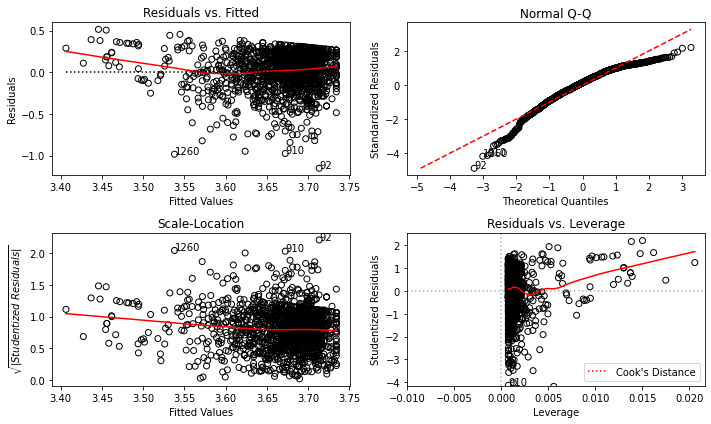

<h1>worthwhile_course</hl>

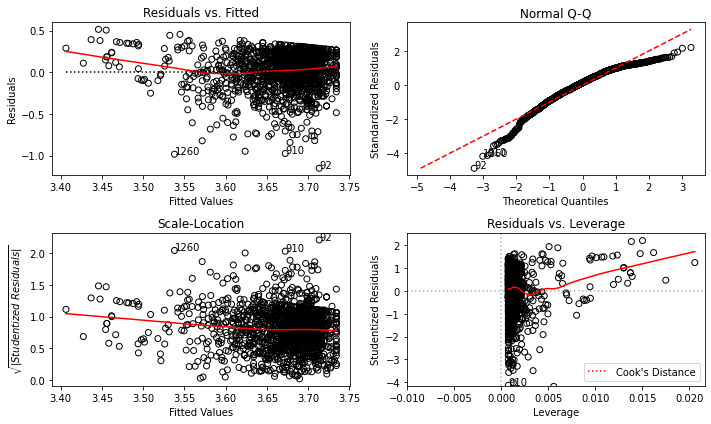

<h1>help_available</hl>

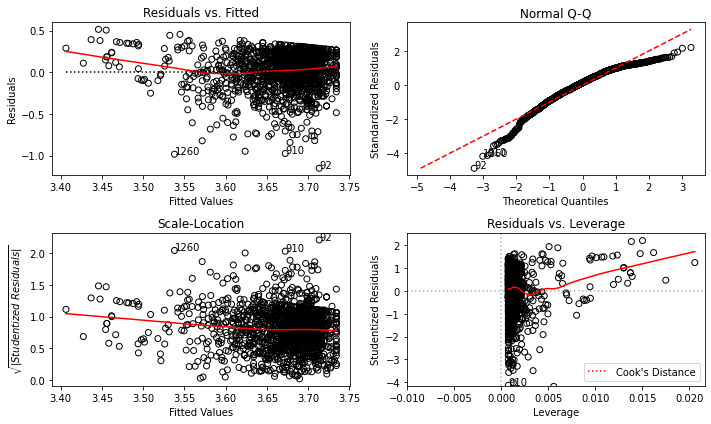

<h1>workload</hl>

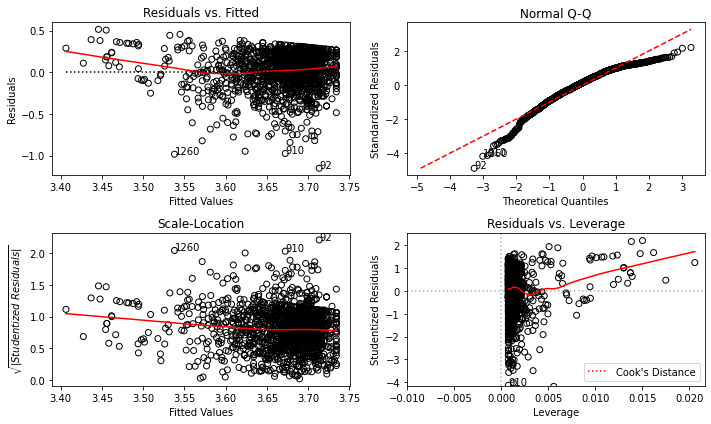

<h1>course_organization</hl>

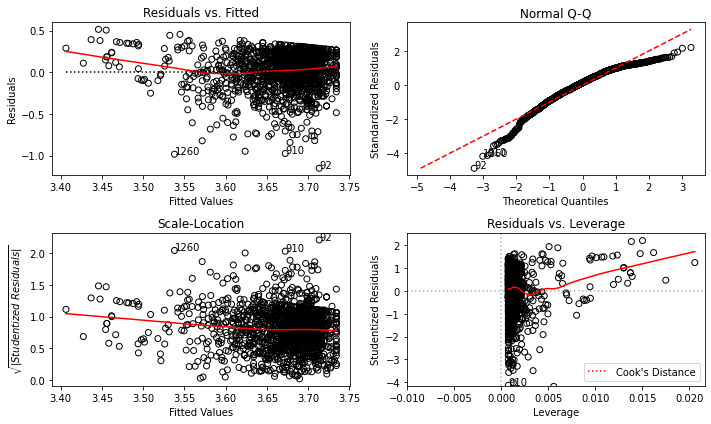

<h1>course_interest</hl>

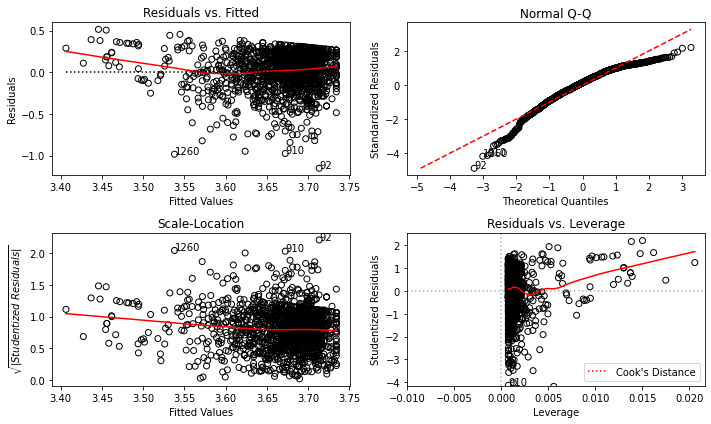

In [38]:
for var, model in zip(Data.columns, models):
    display(Markdown(f"<h1>{var}</hl>"))
    allplots(models[0], figsize=(10, 6))
    plt.show()

In [99]:
formula = "avg_grade ~ "+" + ".join(Data.columns)
model = smf.ols(formula, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              avg_grade   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     29.93
Date:                Thu, 02 Dec 2021   Prob (F-statistic):           9.57e-34
Time:                        01:27:22   Log-Likelihood:                 91.366
No. Observations:                1308   AIC:                            -168.7
Df Residuals:                    1301   BIC:                            -132.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.1622      0.053     59.112      0.000       3.057       3.267
effective_prof          0.4561      0.122      3.727      0.000       0.216       0.696
worthwhile_course      -0.3784      0.151     -2.499      0.013      -0.675      -0.081
help_available         -0.3537      0.111     -3.181      0.002      -0.572      -0.136
workload                0.8884      0.119      7.444      0.000       0.654       1.122
course_organization    -0.3310      0.114     -2.894      0.004      -0.555      -0.107
course_interest         0.3494      0.111      3.140      0.002       0.131       0.568
==============================================================================
Omnibus:                      203.366   Durbin-Watson:                   1.360
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              344.621
Skew:                          -0.998   Prob(JB):                     1.47e-75
Kurtosis:                       4.531   Cond. No.                         65.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

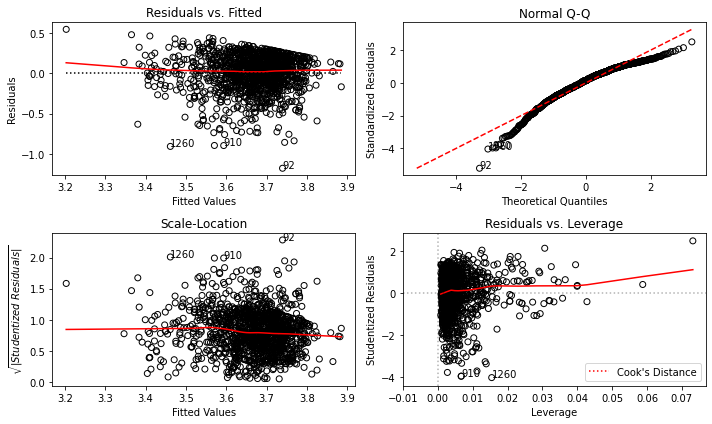

In [56]:
allplots(model, figsize=(10, 6))
plt.show()

In [103]:
#https://towardsdatascience.com/everything-you-need-to-know-about-multicollinearity-2f21f082d6dc
from statsmodels.stats.outliers_influence import variance_inflation_factor

display(pd.DataFrame([variance_inflation_factor(df[Data.columns], i) for i in range(6)], columns=["Variance Inflation Factors"], index=Data.columns))

print(f"The value should be less than {max(10, 1/(1-model.rsquared_adj))} to be considered uncorrelated.")


,Variance Inflation Factors
effective_prof,237.586966
worthwhile_course,382.082275
help_available,175.804029
workload,231.692859
course_organization,216.569216
course_interest,186.768495


The value should be less than 10 to be considered uncorrelated.
